# Project 4: Hack-a-thon
----
Douglas Hundley

Christopher Durso

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("./data/train_data.csv")

In [3]:
test_data = pd.read_csv("./data/test_data.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,wage
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,<=50K


# Cleaning
----

In [5]:
def clean_space(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.replace(" ", "")
    return df

In [6]:
df = clean_space(df)

In [7]:
df = df.drop(columns=["education"])

In [8]:
df["wage"] = np.where(df["wage"] == "<=50K", 0, 1)

# Dummification
----

In [9]:
discrete = ["workclass", "marital-status", "occupation", "relationship",
            "sex", "native-country"]
continuous = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss",
              "hours-per-week", "wage"]

In [10]:
dummies = pd.get_dummies(df[discrete])

In [11]:
df = pd.concat([df[continuous], dummies], axis=1)

In [12]:
df

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Feature Engineering
----

In [13]:
df["gains-losses"] = df["capital-gain"] - df["capital-loss"]
df["younger_than_35"] = np.where(df["age"]<35, 1, 0)
df["older_than_45"] = np.where(df["age"]>45, 1, 0)
df["college_education"] = np.where(df["education-num"] > 12, 1, 0)
df["dropout_before_hs"] = np.where(df["education-num"] < 9, 1, 0)
df["dropout_high_school"] = np.where((df["education-num"] < 12) & (df["education-num"] > 8), 1, 0)
df["older_investing"] = np.where((df["age"]>50) & (df["capital-gain"] > 0), 1, 0)
df["younger_with_losses"] = np.where((df["age"]<40) & (df["capital-loss"] > 0), 1, 0)
df["young_not_working"] = np.where((df["age"] < 55) & (df["hours-per-week"] < 40), 1, 0)
df["married"] = np.where((df["relationship_Husband"] > 0) | (df["relationship_Wife"] > 0), 1, 0)
df["self_employed_not_working"] = np.where((df["workclass_Self-emp-inc"] > 0) | (df["hours-per-week"] < 10), 1, 0)

## test data additional feature:

In [14]:
#df["native-country_Holand-Netherlands"] = 0

# EDA

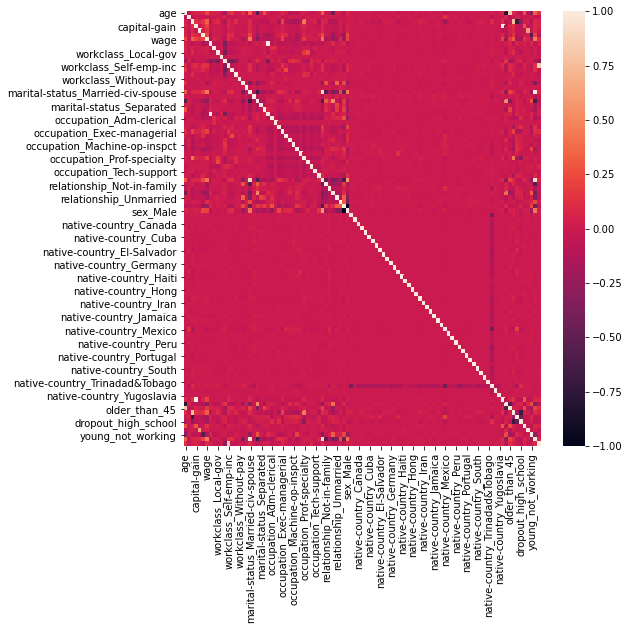

In [15]:
plt.figure(figsize=(8,8), facecolor="w")
sns.heatmap(df.corr());

# Baseline Score
----

In [16]:
baseline = 1 - df["wage"].mean()
print(f"Baseline Score: {baseline:.2%}")

Baseline Score: 75.92%


# Random Forest

In [17]:
features = df.columns

In [18]:
X = df[features].drop(columns=["wage"])
y = df["wage"]

rf = RandomForestClassifier()
ss = StandardScaler()
Xs = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.15,
                                                    random_state=42,
                                                    shuffle=True)

params = {"n_estimators": [100],
          "criterion": ["gini", "entropy"],
          "bootstrap":[True, False],
          "n_jobs": [-1],
          "random_state": [42]}
rf_gscv = GridSearchCV(rf, params, cv=5)
rf_gscv.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfgscv_scores = cross_val_score(rf, X_test, y_test, cv=cv)

print(f"RF GSCV Score: {rfgscv_scores.mean():.2%} +- {rfgscv_scores.std():.2%}")

RF GSCV Score: 85.55% +- 1.25%


In [19]:
print(f"RF GSCV Score: {rfgscv_scores.mean() - baseline:.2%}")

RF GSCV Score: 9.63%


In [20]:
rf_gscv.best_params_
# {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}

{'bootstrap': True,
 'criterion': 'entropy',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42}

In [21]:
y_pred = rf_gscv.predict(X)
cf_matrix = confusion_matrix(y, y_pred)

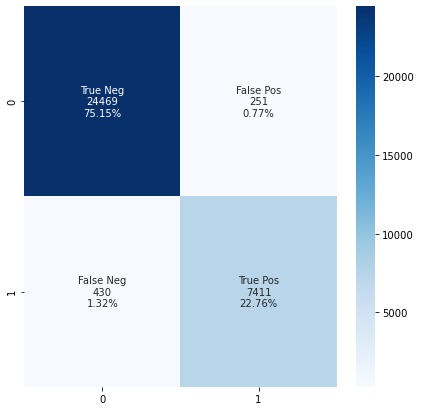

In [22]:
# Credit for code goes to dtuk81 on Medium
# Link: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
plt.figure(figsize=(7,7), facecolor="w")

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues");

# PCA to reduce feature

In [23]:
df[features].drop(columns=["wage"])

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,younger_than_35,older_than_45,college_education,dropout_before_hs,dropout_high_school,older_investing,younger_with_losses,young_not_working,married,self_employed_not_working
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
4,28,338409,13,0,0,40,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
32557,40,154374,9,0,0,40,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
32558,58,151910,9,0,0,40,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
32559,22,201490,9,0,0,20,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [24]:
df_n = df[features].drop(columns=["wage"])

In [25]:
df_sc = StandardScaler().fit_transform(df_n)

In [26]:
pca = PCA().fit(df_sc)

In [27]:
pca1_evec = pca.components_[0]

for weight, event in zip(pca1_evec, df_n.columns):
        print(event, weight)

age 0.23633206794801204
fnlwgt -0.02253924869028301
education-num 0.09254969585814254
capital-gain 0.08167679081638382
capital-loss 0.048137311191260856
hours-per-week 0.15743284764272486
workclass_? -0.0403395353721926
workclass_Federal-gov 0.019904322976943275
workclass_Local-gov 0.02379540030453747
workclass_Never-worked -0.00750703357691737
workclass_Private -0.08999362691513542
workclass_Self-emp-inc 0.09446650697905624
workclass_Self-emp-not-inc 0.08594552324825115
workclass_State-gov 0.006709460736734328
workclass_Without-pay 0.0007569848186392178
marital-status_Divorced -0.08285933473241347
marital-status_Married-AF-spouse -0.001355510418567961
marital-status_Married-civ-spouse 0.35964452951256415
marital-status_Married-spouse-absent -0.02647112814905256
marital-status_Never-married -0.2846728334780598
marital-status_Separated -0.05138084865805762
marital-status_Widowed -0.0299768195595663
occupation_? -0.04074371975199591
occupation_Adm-clerical -0.09264309263637023
occupation

In [28]:
pca_df = pd.DataFrame(pca.transform(df_sc),
                      columns=['pr_comp_' + str(i) for i in range(df_sc.shape[1])])
pca_df.head()

,pr_comp_0,pr_comp_1,pr_comp_2,pr_comp_3,pr_comp_4,pr_comp_5,pr_comp_6,pr_comp_7,pr_comp_8,pr_comp_9,...,pr_comp_88,pr_comp_89,pr_comp_90,pr_comp_91,pr_comp_92,pr_comp_93,pr_comp_94,pr_comp_95,pr_comp_96,pr_comp_97
0,-0.687077,2.031522,-2.222222,0.126386,-0.433365,-0.170231,-1.694876,-0.737307,-1.361226,0.062706,...,0.023180,-1.738809e-16,1.029196e-15,7.603230e-16,-7.425514e-16,-4.802232e-16,9.787901e-17,1.794714e-16,2.891431e-17,2.958126e-16
1,2.985187,1.179347,-0.546760,1.331587,-0.444624,-0.882037,0.208209,-0.113182,-1.221218,-1.788383,...,-0.001361,3.959830e-16,-3.318654e-16,-1.864369e-15,5.056824e-16,-2.411477e-16,1.087630e-15,-1.587305e-15,-1.004498e-16,3.432305e-16
2,-1.053885,-0.282750,0.626030,-1.705604,-0.402308,1.231153,-1.962177,-0.344314,0.440900,0.312882,...,-0.001591,7.142975e-16,-1.302273e-15,4.827672e-16,-5.760180e-16,-1.749119e-16,-1.289900e-15,9.620466e-17,3.342256e-16,-1.091966e-15
3,2.272967,-1.800946,1.913964,-0.227481,1.114810,-0.097340,-0.361447,-0.666232,0.041487,-2.556559,...,0.004514,3.959830e-16,-7.759546e-16,-8.790463e-16,-1.048630e-15,-9.350370e-16,-7.997490e-16,5.082414e-16,9.542621e-16,-1.100059e-15
4,0.258840,1.452191,-1.774143,-0.093963,3.222903,-3.896158,3.605623,0.460287,-0.274067,1.364462,...,-0.048574,-8.530179e-16,-5.539100e-16,-8.096574e-16,-2.436409e-15,2.007054e-15,-2.446375e-16,-2.267316e-15,5.934396e-16,-2.099260e-15


In [29]:
pca_df["wage"] = df["wage"]

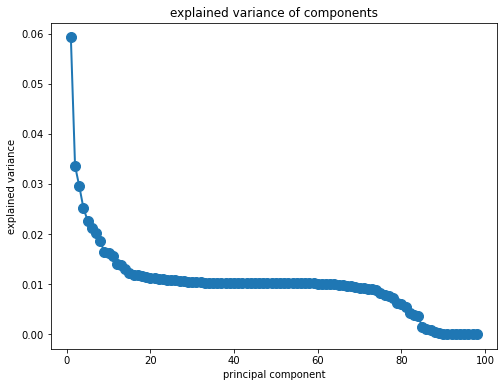

In [30]:
fig, ax = plt.subplots(figsize=(8,6), facecolor="w")
ax.plot(range(1,99), pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, 99), pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance');

# Random Forest 2

In [31]:
X = pca_df.iloc[:, :10]
y = pca_df["wage"]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.15,
                                                    random_state=42,
                                                    shuffle=True)

rf = RandomForestClassifier()

params = {"n_estimators": [100],
          "criterion": ["gini", "entropy"],
          "bootstrap":[True, False],
          "n_jobs": [-1],
          "random_state": [42]}
rf_gscv = GridSearchCV(rf, params, cv=5)
rf_gscv.fit(X_train, y_train)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfgscv_scores = cross_val_score(rf_gscv, X_test, y_test, cv=cv)

print(f"RF GSCV Score: {rfgscv_scores.mean():.2%} +- {rfgscv_scores.std():.2%}")

RF GSCV Score: 84.05% +- 1.36%


In [32]:
print(f"RF GSCV Score: {rfgscv_scores.mean() - baseline:.2%}")

RF GSCV Score: 8.13%


In [33]:
rf_gscv.best_params_
# {'bootstrap': True,'criterion': 'entropy', 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}

{'bootstrap': True,
 'criterion': 'entropy',
 'n_estimators': 100,
 'n_jobs': -1,
 'random_state': 42}

In [34]:
y_pred = rf_gscv.predict(X)
cf_matrix = confusion_matrix(y, y_pred)

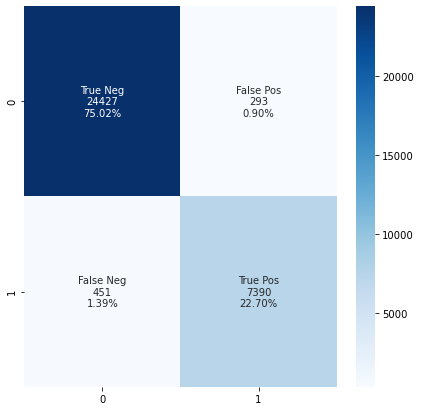

In [35]:
# Credit for code goes to dtuk81 on Medium
# Link: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
plt.figure(figsize=(7,7), facecolor="w")

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues");

# Test Predictions

In [36]:
test_data = pd.read_csv("./data/test_data.csv")

In [37]:
predictions = rf_gscv.predict(df)

ValueError: X has 99 features, but DecisionTreeClassifier is expecting 10 features as input.

In [ ]:
preds = pd.DataFrame(predictions)

In [ ]:
preds.to_csv("./data/predictions.csv", index=False)